In [46]:
import os, sys
import numpy as np
import pandas as pd
import gzip
from scipy.sparse import save_npz, load_npz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

# sys.path.append("../../")
from os.path import dirname
curr_dir = os.path.abspath("")
base_dir = dirname(curr_dir)
sys.path.append(base_dir)
from go_annotation.ontology import ontology

%matplotlib inline

In [71]:
import importlib
importlib.reload(ontology)

<module 'go_annotation.ontology.ontology' from '/home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/go_annotation/ontology/ontology.py'>

## Setup the CAFA3 data

1. Propagate the annotations up the DAG
2. Create a sparse matrix representation

In [72]:
cafa3_dir = "/projects/deepgreen/jlaw/inputs/cafa/CAFA3_training_data"
cafa3_ann = os.path.join(cafa3_dir, "uniprot_sprot_exp.txt")
df = pd.read_csv(cafa3_ann, sep='\t', names=['prot', 'term', 'hierarchy'])

In [3]:
# TODO also compile the test data
#cafa3_test_dir

In [4]:
df.head()

,prot,term,hierarchy
0,P0DJZ0,GO:0030430,C
1,P32234,GO:0005525,F
2,P83011,GO:0043231,C
3,P83010,GO:0043231,C
4,P81928,GO:0007275,P


In [6]:
terms = sorted(df['term'].unique())
len(terms)

24266

In [120]:
go_obo_file = f"{base_dir}/inputs/cafa/go_cafa3.obo.gz"
ont_obj = ontology.Ontology(obo_file=go_obo_file)
anc_terms = ont_obj.get_ancestors(terms)
print(len(anc_terms))
terms = sorted(anc_terms)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/cafa/go_cafa3.obo.gz
28474


In [121]:
# write these terms
terms_file = f"{base_dir}/inputs/cafa/cafa3_terms.txt.gz"
os.makedirs(dirname(terms_file), exist_ok=True)
with gzip.open(terms_file, 'wb') as out:
    out.write(('\n'.join(anc_terms)+'\n').encode())

In [122]:
# now create another ontology object with only the part of the ontology with annotations
ont_obj = ontology.Ontology(obo_file=go_obo_file, restrict_terms_file=terms_file)

reading obo file: /home/jlaw/projects/2020-01-deepgreen/fairseq-uniparc-fork/inputs/cafa/go_cafa3.obo.gz


In [123]:
# now build the annotation matrix and propagate annotations upward
prots, leaf_ann_mat = ontology.build_ann_matrix(df, ont_obj)
ann_mat = ontology.propagate_ann_up_dag(leaf_ann_mat, ont_obj.dag_matrix.T)

In [147]:
# plot the number of annotations per prot
num_ann_per_prot = np.ravel(ann_mat.sum(axis=1))
print(num_ann_per_prot)

[14 14 16 ... 11 12 86]


Text(0.5, 0, '# Annotations')

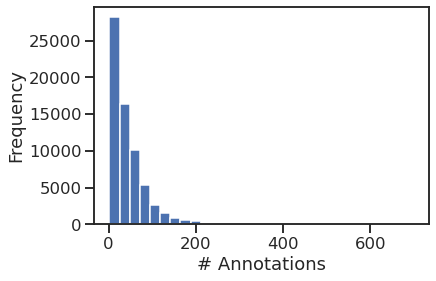

In [152]:
S = pd.Series(num_ann_per_prot)
S.plot.hist(bins=30)
plt.xlabel("# Annotations")
# swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [129]:
# quick manual check for the first protein in the list that the annotations are correct
print(prots[0])
terms = np.asarray(ont_obj.terms)
ann_idx = ann_mat[0,:].nonzero()[1]
print(terms[ann_idx])

['GO:0097458' 'GO:0044464' 'GO:0043005' 'GO:0003674' 'GO:0016714'
 'GO:0004497' 'GO:0004511' 'GO:0005575' 'GO:0042995' 'GO:0003824'
 'GO:0016705' 'GO:0016491' 'GO:0043204' 'GO:0070852']


In [132]:
# split the proteins into three sets uniformly at random: train, valid and test
# TODO also split the proteins by uniref50 cluster?
# train, valid, test = np.split()
prot_arr = np.arange(len(prots))
# shuffle the indexes in-place
np.random.shuffle(prot_arr)
split_size = int(np.floor(len(prots) * .1))
test_idx = int(np.floor(split_size*.5))
valid_idx = split_size
# split 
print(f"splitting the proteins with 5% ({test_idx}) left out for test, and 5% ({test_idx}) for valid.")
test, valid, train = np.split(prot_arr, [test_idx, valid_idx])

splitting the proteins with 5% (3342) left out for test, and 5% (3342) for valid.


In [133]:
# copied from here: https://stackoverflow.com/a/29805905/7483950
def read_fasta(fp):
        name, seq = None, []
        for line in fp:
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line[1:], []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [134]:
# load the uniprot fasta file
# keep track of the order of the proteins
fasta_file = "/projects/deepgreen/jlaw/inputs/cafa/CAFA3_training_data/uniprot_sprot_exp.fasta"
print(f"reading {fasta_file}")
sequences = {}
with open(fasta_file, 'r') as f:
    for name, seq in read_fasta(f):
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
#         print(name, seq)
        sequences[name] = seq

print(f"\t{len(sequences)} read")

reading /projects/deepgreen/jlaw/inputs/cafa/CAFA3_training_data/uniprot_sprot_exp.fasta
	66841 read


In [135]:
def write_split_prots(prot_split, sequences, out_file):
    print(f"writing {len(prot_split)} prot sequences to {out_file}")
    with open(out_file, 'w') as out:
        for prot in prot_split:
            out.write(' '.join(sequences[prot]) + '\n')

In [136]:
# write one protein sequence per line, separating AA by spaces, as expected by fairseq
out_dir = "/projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/input0"
prots = np.asarray(prots)
for prot_split, split in [
        (prots[test], 'test'),
        (prots[valid], 'valid'),
        (prots[train], 'train')]:
    out_file = f"{out_dir}/{split}.raw"
    write_split_prots(prot_split, sequences, out_file)

writing 3342 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/input0/test.raw
writing 3342 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/input0/valid.raw
writing 60157 prot sequences to /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/input0/train.raw


In [138]:
# write the corresponding annotation matrix into train and validate datasets
out_dir = "/projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/label/"
for prot_split_idx, split in [(test, 'test'),
                              (valid, 'valid'),
                              (train, 'train')]:
    split_ann_mat = ann_mat[prot_split_idx,:]
    print(split_ann_mat.shape)
    out_file = f"{out_dir}/{split}.npz"
    print(f"writing {out_file}")
    save_npz(out_file, split_ann_mat)

(3342, 28474)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/label//test.npz
(3342, 28474)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/label//valid.npz
(60157, 28474)
writing /projects/deepgreen/jlaw/swissprot_go_annotation/fairseq_cafa3/label//train.npz


In [139]:
ann_mat.shape

(66841, 28474)

In [155]:
# command I used: 
#fairseq-preprocess --trainpref ./input0/train.raw --validpref ./input0/valid.raw --testpref ./input0/test.raw  --destdir ./input0/ --only-source

In [20]:
# Peter's cafa files
label_file = "/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_cafa3/label/train.npz"
label_mat = load_npz(label_file)
print(label_mat.shape)

(63629, 32012)


## Peter's code:

In [2]:
import os
swissprot_dir = '/gpfs/alpine/bie108/proj-shared/swissprot/'

In [3]:
swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))

In [4]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

In [5]:
swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated = swissprot_annotated[swissprot_annotated.length < 10000]

In [6]:
uniref50_clusters = swissprot_annotated['UniRef50 ID'].unique()
print(len(uniref50_clusters))
np.random.seed(1)
np.random.shuffle(uniref50_clusters)
test, valid, train = np.split(uniref50_clusters, [4000, 8000])

174009


In [7]:
len(train)

166009

In [8]:
166009 / (6 * 24)

1152.8402777777778

In [9]:
swissprot_train = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(train)].sample(frac=1., random_state=1)
swissprot_valid = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(valid)].sample(frac=1., random_state=1)

In [10]:
len(swissprot_train) // (6 * 24)

3579

In [11]:
go_terms.head()

,GENE PRODUCT DB,GENE PRODUCT ID,SYMBOL,QUALIFIER,GO TERM,GO ASPECT,ECO ID,GO EVIDENCE CODE,REFERENCE,WITH/FROM,TAXON ID,ASSIGNED BY,ANNOTATION EXTENSION,DATE
0,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571|InterPro:IPR018354,8613,InterPro,None,20200613
1,UniProtKB,A2CKF6,A2CKF6,involved_in,GO:0009405,P,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571,8613,InterPro,None,20200613
2,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0964,8613,UniProt,None,20200613
3,UniProtKB,A2CKF6,A2CKF6,enables,GO:0090729,F,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0800,8613,UniProt,None,20200613
4,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0035792,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0629,8613,UniProt,None,20200613


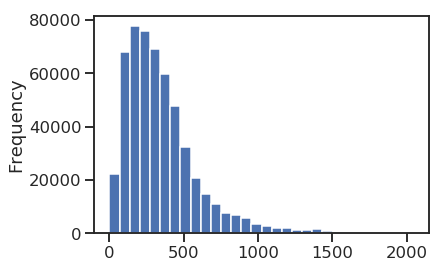

In [12]:
swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [13]:
import sys
sys.path.append('..')

In [14]:
from bert.dataset import encode
from bert.go import Ontology

ont = Ontology(threshold=500)
ont.total_nodes

3181

In [15]:
grouped_go_terms = go_terms.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)

In [16]:
from tqdm import tqdm

In [17]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _serialize_array(value):
    return _bytes_feature(tf.io.serialize_tensor(value))

def inputs_generator(swissprot_df):
    for _, row in tqdm(swissprot_df.iterrows(), total=len(swissprot_df)):
#        sequence = encode(row.sequence, max_seq_len)
        ancestor_array = ont.termlist_to_array(ont.get_ancestors(
            grouped_go_terms[row.accession]), dtype=int)
        
        features = {
            'sequence': _bytes_feature(row.sequence.encode('utf8')),
            'annotation': _serialize_array(ancestor_array)
        }
        
        example_proto = tf.train.Example(features=tf.train.Features(feature=features))
        yield example_proto.SerializeToString()

In [18]:
# example = next(inputs_generator(swissprot_annotated))

# parsed = tf.io.parse_single_example(example, features={
#         'sequence': tf.io.FixedLenFeature([], tf.string, default_value=''),
#         'annotation': tf.io.FixedLenFeature([], tf.string, default_value=''),
#     })

# tf.io.parse_tensor(parsed['annotation'], out_type=tf.int64)

In [25]:
np.savez_compressed('uniref50_split.npz', train=train, valid=valid, test=test)
pd.Series(ont.term_index).to_csv('term_index.csv', header=False)

In [26]:
# Preprocess and write the train dataset to disk
serialized_train_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_train),
    output_types=tf.string, output_shapes=())

filename = os.path.join(swissprot_dir, 'tfrecords', 'go_train.tfrecord.gz')
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_train_dataset)


# Preprocess and write the valid dataset to disk
serialized_valid_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_valid),
    output_types=tf.string, output_shapes=())

filename = os.path.join(swissprot_dir, 'tfrecords', 'go_valid.tfrecord.gz')
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_valid_dataset)

100%|██████████| 12002/12002 [00:21<00:00, 551.35it/s]
